# Simulated Annealing

4P - "Get acquainted with the Simulated Annealing (SA) algorithm by running the Python script provided in the lecture materials. It demonstrates the application of the SA algorithm to solve the Quadratic Assignment Problem (QAP) discussed in the lecture.
- a) Try to choose SA algorithm parameters that allow solving the QAP for several other instances.
- b) The histogram in the script shows the distribution of objective function values for randomly generated solutions. Create a similar histogram for solutions generated by the SA algorithm (for a specific QAP instance and fixed algorithm parameters). This will require multiple algorithm runs and likely lengthy computations.
- c) Check how many "successes" (a solution q better than solution p) and "accepted failures" (a solution q worse than solution p but accepted) there are in successive iterations of the SA algorithm (as time passes, "successes" and "accepted failures" become less frequent) for several selected algorithm parameter settings. Illustrate this phenomenon with a graph.
- d) How can you measure the distance between permutations? Examine the relationship between changes in the objective function value f(p) - f(q) in successes and the distance between permutations p and q. Illustrate this with a graph.
- e) Attempt to improve the algorithm by proposing a different failure acceptance criterion."

Literatura:

* [1] Burkard, R., Cela, E., Pardalos, P., Pitsoulis, L., "The Quadratic Assignment Problem", http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.217.1914

* [2] QAPLIB, https://qaplib.mgi.polymtl.ca/

* [3] NUG12, https://qaplib.mgi.polymtl.ca/data.d/nug12.dat

In [ ]:
! pip install gdown

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.stats import mode
import time
import urllib.request
import tqdm
from IPython.display import Image
from tqdm.auto import tqdm
%matplotlib inline

In [ ]:
QAP_INSTANCE_URL = 'https://qaplib.mgi.polymtl.ca/data.d/nug12.dat'

### Reading input data

In [ ]:
qap_instance_file = urllib.request.urlopen(QAP_INSTANCE_URL)

line = qap_instance_file.readline()
n = int(line.decode()[:-1].split()[0])
print('Problem size: %d' % n)

A = np.empty((n, n))
qap_instance_file.readline()
for i in range(n):
    line = qap_instance_file.readline()
    A[i, :] = list(map(int, line.decode()[:-1].split()))
print('Flow matrix:\n', A)

B = np.empty((n, n))
qap_instance_file.readline()
for i in range(n):
    line = qap_instance_file.readline()
    B[i, :] = list(map(int, line.decode()[:-1].split()))
print('Distance matrix:\n', B)

Problem size: 12
Flow matrix:
 [[0. 1. 2. 3. 1. 2. 3. 4. 2. 3. 4. 5.]
 [1. 0. 1. 2. 2. 1. 2. 3. 3. 2. 3. 4.]
 [2. 1. 0. 1. 3. 2. 1. 2. 4. 3. 2. 3.]
 [3. 2. 1. 0. 4. 3. 2. 1. 5. 4. 3. 2.]
 [1. 2. 3. 4. 0. 1. 2. 3. 1. 2. 3. 4.]
 [2. 1. 2. 3. 1. 0. 1. 2. 2. 1. 2. 3.]
 [3. 2. 1. 2. 2. 1. 0. 1. 3. 2. 1. 2.]
 [4. 3. 2. 1. 3. 2. 1. 0. 4. 3. 2. 1.]
 [2. 3. 4. 5. 1. 2. 3. 4. 0. 1. 2. 3.]
 [3. 2. 3. 4. 2. 1. 2. 3. 1. 0. 1. 2.]
 [4. 3. 2. 3. 3. 2. 1. 2. 2. 1. 0. 1.]
 [5. 4. 3. 2. 4. 3. 2. 1. 3. 2. 1. 0.]]
Distance matrix:
 [[ 0.  5.  2.  4.  1.  0.  0.  6.  2.  1.  1.  1.]
 [ 5.  0.  3.  0.  2.  2.  2.  0.  4.  5.  0.  0.]
 [ 2.  3.  0.  0.  0.  0.  0.  5.  5.  2.  2.  2.]
 [ 4.  0.  0.  0.  5.  2.  2. 10.  0.  0.  5.  5.]
 [ 1.  2.  0.  5.  0. 10.  0.  0.  0.  5.  1.  1.]
 [ 0.  2.  0.  2. 10.  0.  5.  1.  1.  5.  4.  0.]
 [ 0.  2.  0.  2.  0.  5.  0. 10.  5.  2.  3.  3.]
 [ 6.  0.  5. 10.  0.  1. 10.  0.  0.  0.  5.  0.]
 [ 2.  4.  5.  0.  0.  1.  5.  0.  0.  0. 10. 10.]
 [ 1.  5.  2.  0.  5.  

In [ ]:
def get_nug(no):
    QAP_INSTANCE_URL = f'https://qaplib.mgi.polymtl.ca/data.d/nug{no}.dat'
    qap_instance_file = urllib.request.urlopen(QAP_INSTANCE_URL)

    line = qap_instance_file.readline()
    n = int(line.decode()[:-1].split()[0])
    # print('Problem size: %d' % n)

    A = np.empty((n, n))
    qap_instance_file.readline()
    for i in range(n):
        line = qap_instance_file.readline()
        A[i, :] = list(map(int, line.decode()[:-1].split()))
    # print('Flow matrix:\n', A)

    B = np.empty((n, n))
    qap_instance_file.readline()
    for i in range(n):
        line = qap_instance_file.readline()
        B[i, :] = list(map(int, line.decode()[:-1].split()))
    # print('Distance matrix:\n', B)

    return n, A, B

### Objective function


In [ ]:
def qap_objective_function(p):
    s = 0.0
    for i in range(n):
        s += (A[i, :] * B[p[i], p]).sum()
    return s

In [ ]:
p = [11, 6, 8, 2, 3, 7, 10, 0, 4, 5, 9, 1]
print(qap_objective_function(p), p)

578.0 [11, 6, 8, 2, 3, 7, 10, 0, 4, 5, 9, 1]


### Random Sampling

In [ ]:
t0 = time.time()

T = 1000000

permutations = np.empty((T, n), dtype=np.int64)
costs = np.zeros(T)
for i in range(T):
    permutations[i, :] = np.random.permutation(n)
    costs[i] = qap_objective_function(permutations[i, :])

print("time:",time.time() - t0)

p = permutations[costs.argmin(), :]
print(qap_objective_function(p), p)

time: 90.67393183708191
604.0 [ 3  4  5  9  7  6 10  2  0 11  8  1]


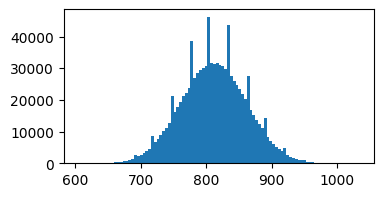

811.975694 49.756616898844364


In [ ]:
plt.figure(figsize=(4,2))
plt.hist(costs, bins=100)
plt.show()

print(costs.mean(), costs.std())

### Simulated Annealing

模拟退火 \
<img src="https://drive.google.com/uc?id=1n7iYOLV9qeJH6tWJnMYCvmPV0-j_k5_i" alt="drawing" width="400"/>
<img src="https://drive.google.com/uc?id=1lu5kySb5CTlinuqo5zgimtn4TaJpP04J" alt="drawing" width="400"/>

In [ ]:
def random_neighbor(p, radius):
    q = p.copy()
    for r in range(radius):
        i, j = np.random.choice(n, 2, replace=False)
        q[i], q[j] = q[j], q[i]
    return q

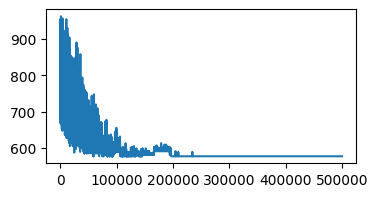

62.34728264808655 578.0


In [ ]:
T = 500000
radius = 1
alpha = 1.0

t0 = time.time()

p = np.random.permutation(n)
p_cost = qap_objective_function(p)
costs = np.zeros(T)
for t in range(T):
    q = random_neighbor(p, radius)
    q_cost = qap_objective_function(q)
    if(q_cost < p_cost):
        p, p_cost = q, q_cost
    elif(np.random.rand() < np.exp(- alpha * (q_cost - p_cost) * t/T)):
        p, p_cost = q, q_cost
    costs[t] = p_cost
plt.figure(figsize=(4,2))
plt.plot(costs)
plt.show()
print(time.time() - t0, costs.min())

In [ ]:
def basicSA(T, radius, alpha, n, plot = False):
    t0 = time.time()
    p = np.random.permutation(n)
    p_cost = qap_objective_function(p)
    costs = np.zeros(T)
    for t in range(T):
        q = random_neighbor(p, radius)
        q_cost = qap_objective_function(q)
        if(q_cost < p_cost):
            p, p_cost = q, q_cost
        elif(np.random.rand() < np.exp(- alpha * (q_cost - p_cost) * t/T)):
            p, p_cost = q, q_cost
        costs[t] = p_cost
    if plot == True:
        plt.figure(figsize=(4,2))
        plt.plot(costs)
        plt.show()
    return time.time() - t0, costs.min()

### - a) Try to choose SA algorithm parameters that allow solving the QAP for several other instances.


NUG14,T=500000,radius=1,alpha=0.8


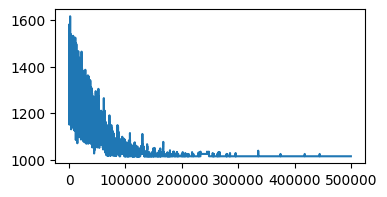

NUG15,T=500000,radius=1,alpha=0.8


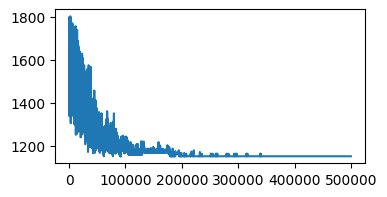

NUG16a,T=500000,radius=1,alpha=0.8


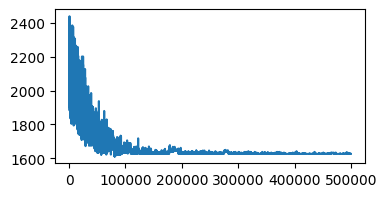

NUG17,T=500000,radius=1,alpha=0.8


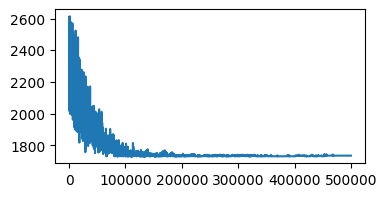

NUG18,T=500000,radius=1,alpha=0.8


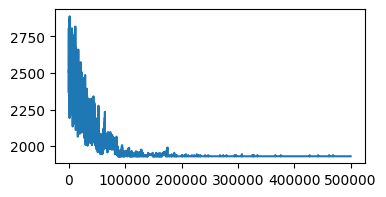

In [ ]:
instances = [14, 15, '16a', 17, 18,]
for i in instances:
    n , A , B = get_nug(i)
    T = 500000
    radius = 1
    alpha = 0.8
    print(f'NUG{i},T={T},radius={radius},alpha={alpha}')
    basicSA(T, radius, alpha, n, plot = True)

### - b) The histogram in the script shows the distribution of objective function values for randomly generated solutions. Create a similar histogram for solutions generated by the SA algorithm (for a specific QAP instance and fixed algorithm parameters). This will require multiple algorithm runs and likely lengthy computations.

In [ ]:
iters = 500
results = np.zeros(500)
n, A, B = get_nug(15)
T, radius, alpha = 50000, 1, 1.0
for i in tqdm(range(iters)):
    results[i] = basicSA(T, radius, alpha, n, False)[1]

  0%|          | 0/500 [00:00<?, ?it/s]

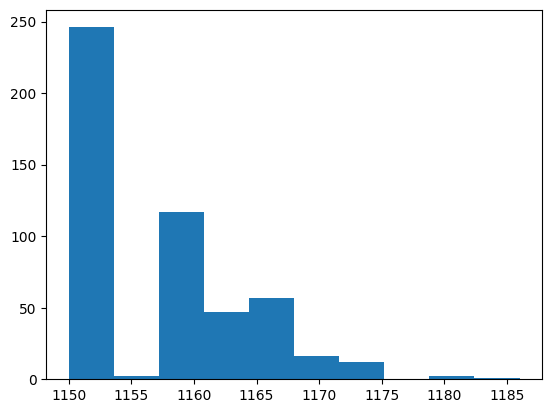

In [ ]:
plt.figure()
plt.hist(results)
plt.show()

### - c) Check how many "successes" (a solution q better than solution p) and "accepted failures" (a solution q worse than solution p but accepted) there are in successive iterations of the SA algorithm (as time passes, "successes" and "accepted failures" become less frequent) for several selected algorithm parameter settings. Illustrate this phenomenon with a graph.

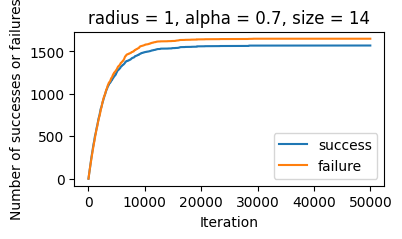

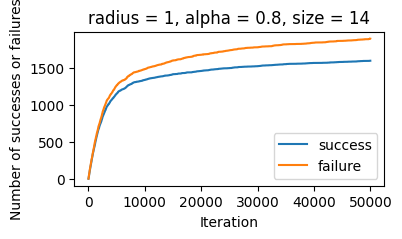

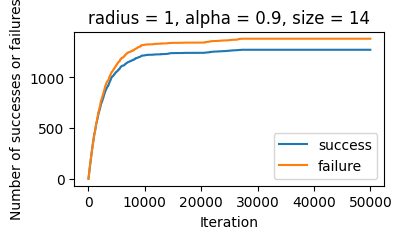

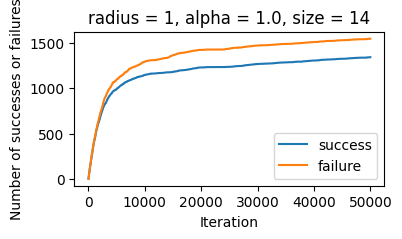

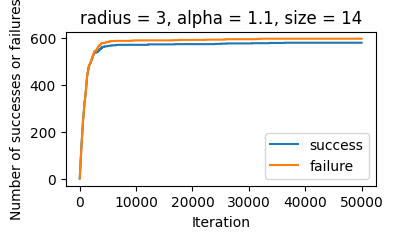

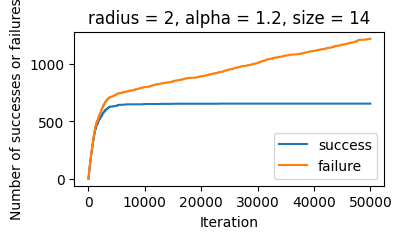

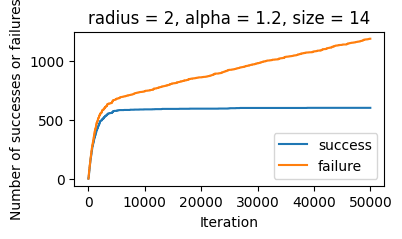

In [ ]:
params = [(1,0.7), (1, 0.8), (1, 0.9), (1, 1.0), (3, 1.1), (2, 1.2), (3, 1.2)]

n, A, B = get_nug(14)
T = 50000

for param in params:

    radius = param[0]
    alpha = param[1]
    t0 = time.time()
    succs = np.zeros(T)
    fails = np.zeros(T)
    s_count, f_count = 0, 0
    p = np.random.permutation(n)
    p_cost = qap_objective_function(p)

    for t in range(T):
        q = random_neighbor(p, radius)
        q_cost = qap_objective_function(q)
        if(q_cost < p_cost):
            p, p_cost = q, q_cost
            s_count += 1
        elif(np.random.rand() < np.exp(- alpha * (q_cost - p_cost) * t/T)):
            p, p_cost = q, q_cost
            f_count += 1
        succs[t] = s_count
        fails[t] = f_count
        #costs[t] = p_cost

    plt.figure(figsize=(4,2))
    plt.title(f'radius = {radius}, alpha = {alpha}, size = {n}')
    plt.plot(succs, label = "success")
    plt.ylabel("Number of successes or failures")
    plt.xlabel("Iteration")
    plt.plot(fails, label = "failure")
    plt.legend(loc = "lower right")
    plt.show()

NUG14,T=500000,radius=1,alpha=0.8


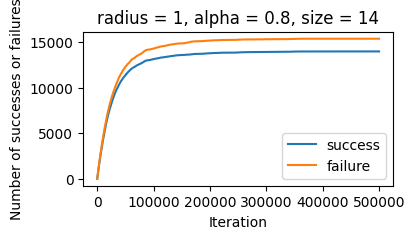

NUG15,T=500000,radius=1,alpha=0.8


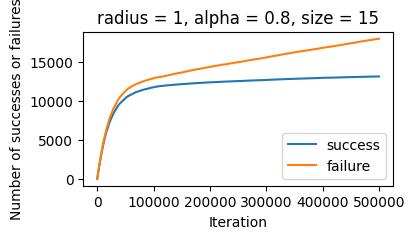

NUG16a,T=500000,radius=1,alpha=0.8


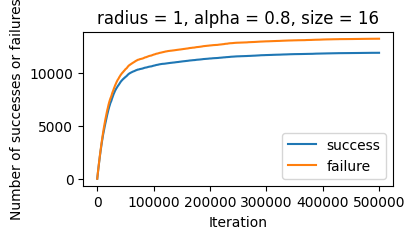

NUG17,T=500000,radius=1,alpha=0.8


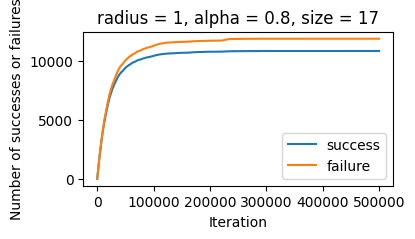

NUG18,T=500000,radius=1,alpha=0.8


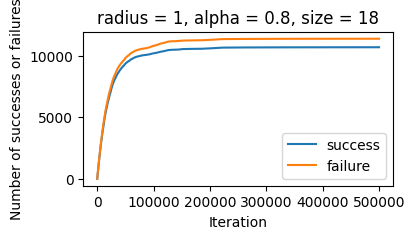

In [ ]:
instances = [14, 15, '16a', 17, 18,]
for i in instances:
    n , A , B = get_nug(i)
    T = 500000
    radius = 1
    alpha = 0.8
    print(f'NUG{i},T={T},radius={radius},alpha={alpha}')
    t0 = time.time()
    succs = np.zeros(T)
    fails = np.zeros(T)
    s_count, f_count = 0, 0
    p = np.random.permutation(n)
    p_cost = qap_objective_function(p)

    for t in range(T):
        q = random_neighbor(p, radius)
        q_cost = qap_objective_function(q)
        if(q_cost < p_cost):
            p, p_cost = q, q_cost
            s_count += 1
        elif(np.random.rand() < np.exp(- alpha * (q_cost - p_cost) * t/T)):
            p, p_cost = q, q_cost
            f_count += 1
        succs[t] = s_count
        fails[t] = f_count

    plt.figure(figsize=(4,2))
    plt.title(f'radius = {radius}, alpha = {alpha}, size = {n}')
    plt.plot(succs, label = "success")
    plt.ylabel("Number of successes or failures")
    plt.xlabel("Iteration")
    plt.plot(fails, label = "failure")
    plt.legend(loc = "lower right")
    plt.show()

### - d) How can you measure the distance between permutations? Examine the relationship between changes in the objective function value f(p) - f(q) in successes and the distance between permutations p and q. Illustrate this with a graph.


In [ ]:
from scipy.stats import kendalltau

98.79302978515625 1018.0


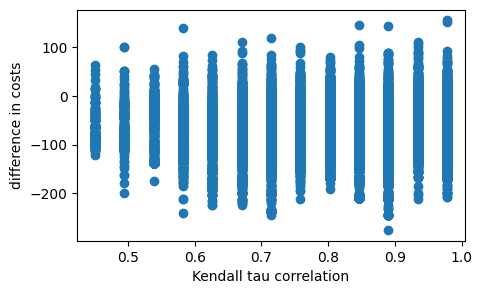

In [ ]:
n, A, B = get_nug(14)
T = 50000
radius = 1
alpha = 1.0

p = np.random.permutation(n)
p_cost = qap_objective_function(p)

costs = np.zeros(T)
dist = np.zeros(T)
diff = np.zeros(T)

for t in range(T):
    q = random_neighbor(p, radius)
    dist[t] = kendalltau(p,q)[0]
    q_cost = qap_objective_function(q)
    diff[t] = p_cost - q_cost
    if(q_cost < p_cost):
        p, p_cost = q, q_cost
    elif(np.random.rand() < np.exp(- alpha * (q_cost - p_cost) * t/T)):
        p, p_cost = q, q_cost
    costs[t] = p_cost

print(time.time() - t0, costs.min())

plt.figure(figsize=(5,3))
plt.ylabel("difference in costs")
plt.xlabel("Kendall tau correlation")
plt.scatter(dist, diff)
plt.show()

- e) Attempt to improve the algorithm by proposing a different failure acceptance criterion."

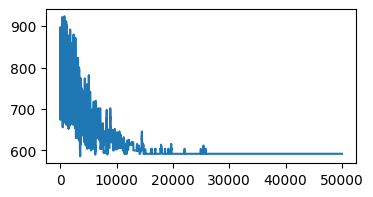

(5.059423446655273, 586.0)

In [ ]:
n, A, B = get_nug(12)
basicSA(T=50000, radius = 1, alpha = 0.8, n=n, plot=True)

#### cooling_schedule

In [ ]:
def exponential_cooling_schedule(init_temperature, alpha, t):
    return init_temperature * (alpha ** t)

def basicSA_cooling(T, radius, alpha, n, plot = False):
    t0 = time.time()
    p = np.random.permutation(n)
    p_cost = qap_objective_function(p)
    costs = np.zeros(T)
    for t in range(T):
        temperature = T * (1 - t / T)  # cooling schedule
        q = random_neighbor(p, radius)
        q_cost = qap_objective_function(q)
        if(q_cost < p_cost):
            p, p_cost = q, q_cost
        elif(np.random.rand() < np.exp(- alpha * (q_cost - p_cost) * t/ temperature)):
            p, p_cost = q, q_cost
        costs[t] = p_cost
    if plot == True:
        plt.figure(figsize=(4,2))
        plt.plot(costs)
        plt.show()
    return time.time() - t0, costs.min()

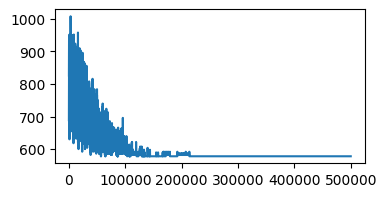

(61.41006588935852, 578.0)

In [ ]:
n, A, B = get_nug(12)
basicSA_cooling(T=500000, radius = 1, alpha = 0.8, n=n, plot=True)

-------------------------------

# PBIL

2P
- a) Implement the Population-Based Incremental Learning (PBIL) algorithm.
- b) Test its performance on several simple optimization problems (OneMax, Deceptive OneMax, K-Deceptive OneMax). Conduct computational experiments for different problem sizes and various algorithm settings. Analyze the results thoroughly.

### - a) Implement the PBIL algorithm.


In [ ]:
def binary_random(p):
    return 1 if random.uniform(0, 1) < p else 0

def random_population(p, N, d):
    return [[binary_random(p[j]) for j in range(d)] for _ in range(N)]

def evaluate_pop(population, fitness_func):
    best_individual = None
    best_score = float('-inf')
    worst_score = float('inf')
    mean_score = 0.0
    for individual in population:
        cost = fitness_func(individual)
        mean_score += cost
        if cost > best_score:
            best_score = cost
            best_individual = individual
        if cost < worst_score:
            worst_score = cost
    mean_score /= len(population)

    return best_individual, best_score, worst_score, mean_score

In [ ]:
def pbil(Func, d ,N, T1, T2, T3, it):
    prob = [0.5 for _ in range(d)]
    pop = random_population(prob, N, d)
    data = np.zeros((3, it))
    probabilities = []

    for i in range(it):
        scores = evaluate_pop(pop, Func)
        x = scores[0]
        probabilities.append(prob.copy())
        for j in range(3):
            data[j][i] = scores[j + 1]
        for k in range(d):
            prob[k] = prob[k] * (1 - T1) + x[k] * T1
        for k in range(d):
            if random.uniform(0, 1) < T2:
                prob[k] = prob[k] * (1 - T3) + binary_random(0.5) * T3
        pop = random_population(prob, N, d)
    return data, probabilities

def plot(title, data, probabilities):
    title_fontsize = 8
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
    fig.suptitle(title,  fontsize= title_fontsize)
    ax1.set_title('Probabilities',  fontsize= title_fontsize)
    ax2.set_title('Costs',  fontsize= title_fontsize)
    ax1.plot(probabilities)
    ax2.plot(data[0], label="Top scores")
    ax2.plot(data[2], label="Mean scores")
    ax2.plot(data[1], label="Worst scores")
    ax2.legend(loc='lower right')
    plt.show()

In [ ]:
def OneMax(p):
    return sum(p)

def Deceptive_OneMax(p):
    s = sum(p)
    if s > 0:
        return s
    return len(p) + 1

def K_Deceptive_OneMax(p, k=10):
    n = len(p)
    fitness = 0
    for i in range(0, n, k):
        block = p[i:i + k]
        fitness += sum(block)
    return fitness

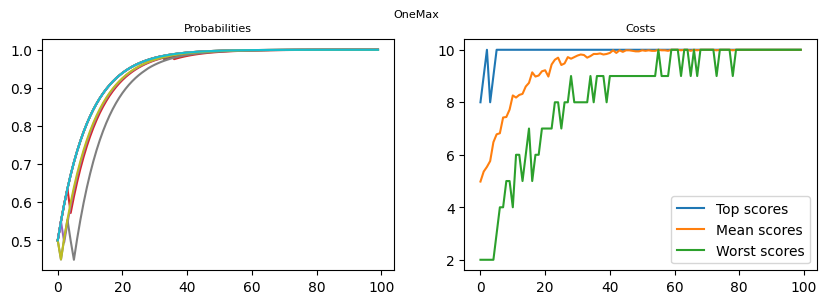

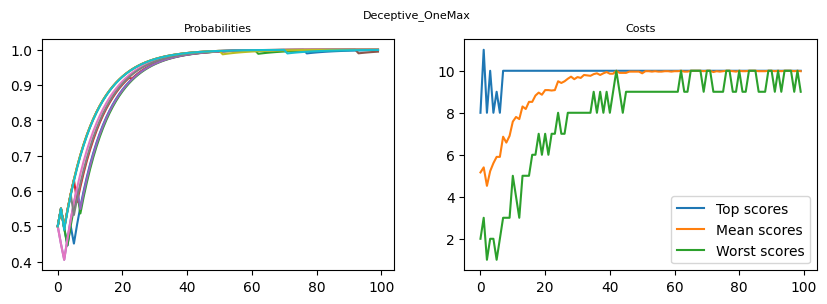

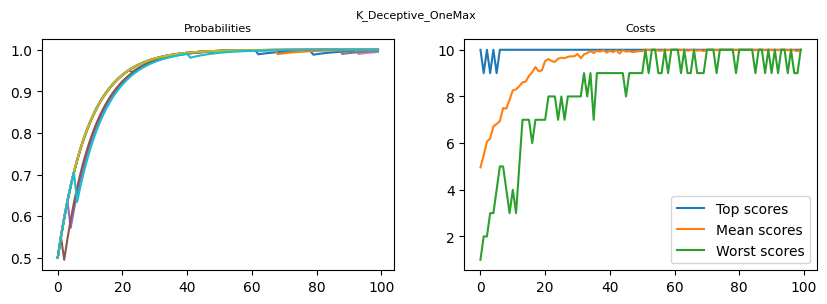

In [ ]:
d = 10
N = 50
T1 = 0.1
T2 = 0.01
T3 = 0.01
iterations = 100
funcs = [OneMax, Deceptive_OneMax, K_Deceptive_OneMax]
for F in funcs:
    data, probabilities = pbil(F,d,  N, T1, T2, T3, iterations)
    plot(f'{F.__name__}', data, probabilities)

### - b) Test its performance on several simple optimization problems(OneMax, Deceptive OneMax, K-Deceptive OneMax). Conduct computational experiments for different problem sizes and various algorithm settings. Analyze the results thoroughly.

In [ ]:
args = [[OneMax, 100,50,0.2, 0.01, 0.01,100],
        [Deceptive_OneMax, 100,50,0.2, 0.01, 0.01,100],
        [K_Deceptive_OneMax, 100,50,0.2, 0.01, 0.01,100],
        [OneMax, 150,75,0.1, 0.01, 0.02,200],
        [Deceptive_OneMax, 150,75,0.1, 0.01, 0.02,200],
        [K_Deceptive_OneMax, 150,75,0.1, 0.01, 0.02,200],
        [OneMax, 125,75,0.1, 0.01, 0.02,250],
        [Deceptive_OneMax, 125,75,0.1, 0.01, 0.02,250],
        [K_Deceptive_OneMax, 125,75,0.1, 0.01, 0.02,250],
        ]

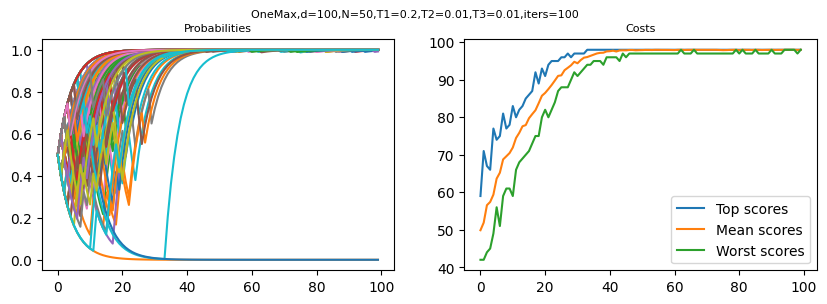

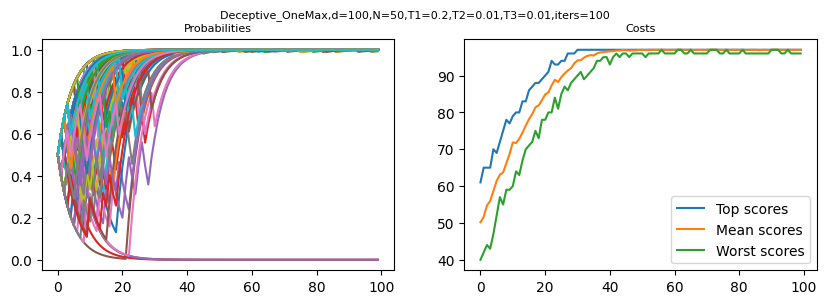

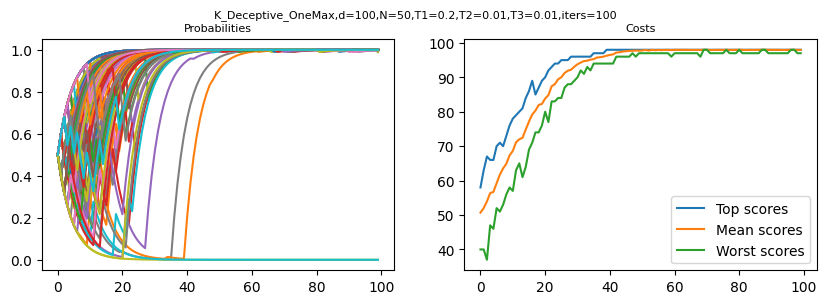

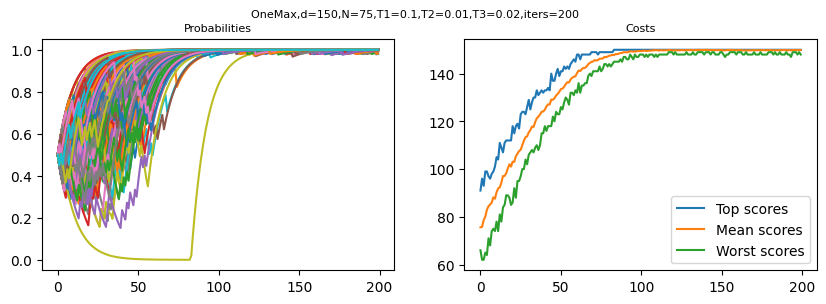

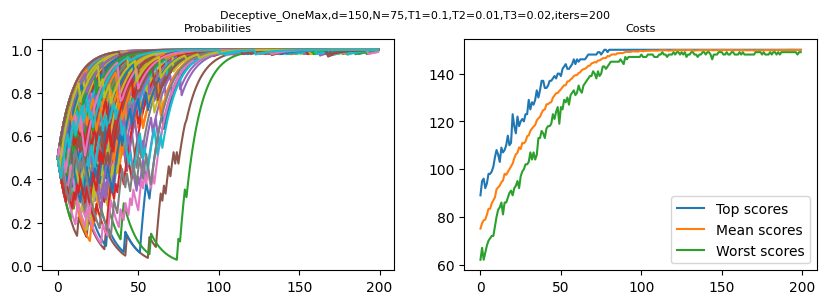

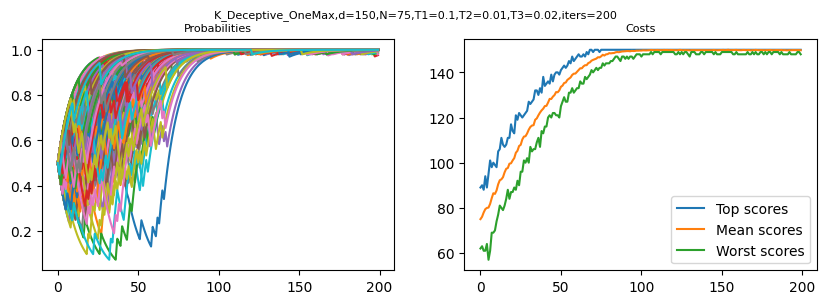

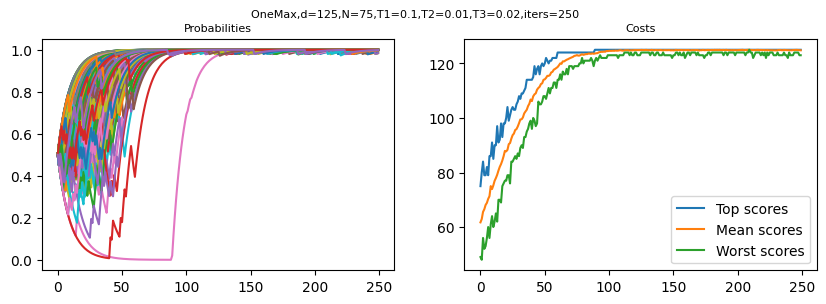

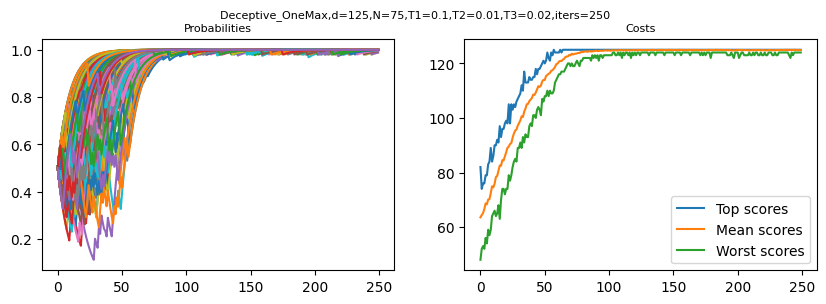

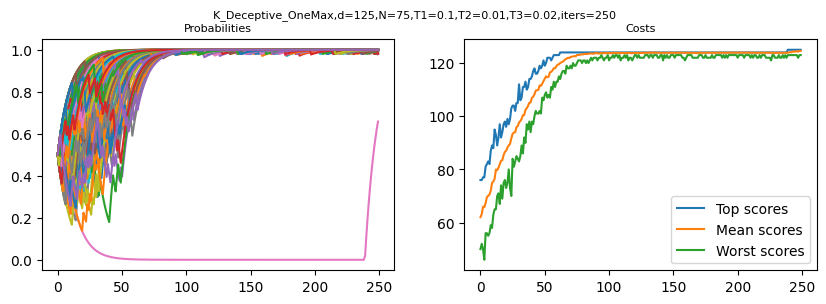

In [ ]:
for i in args:
    data, probabilities = pbil(*i)
    func,d,N,T1,T2,T3,iterations = i
    plot(f'{func.__name__},d={d},N={N},T1={T1},T2={T2},T3={T3},iters={iterations} ', data, probabilities)

## multispectral image
Given a multispectral image with 3 spectral bands and a size of 106 x 148 points (stored in the BSQ format as files ImageRaw.bsq and ImageRaw.hdr). Each point in the image can be represented as a vector of size 3 x 1, and thus, the entire image can be represented as a matrix of size 3 x 15688 (stored in the file ImageRaw.txt). There is a ground-truth classification of this image - it is a bitmap with 11 colors and a size of 106 x 148 points (stored in the file ImageExpert.bmp). It can be represented as a vector of size 1 x 15688 with values from the set {1, 2, ..., 11} (stored in the file ImageExpert.txt).

We are only interested in 3 classes of points (classes 3, 7, and 9), so we remove the other points from the data, resulting in a matrix X of size 3 x 9350 (multispectral image points) and a vector C of size 1 x 9350 with values from the set {1, 2, 3} (ground-truth classification). These data are stored in the files ImageRawReduced.txt and ImageExpertReduced.txt, respectively.

There are 266 pre-defined classification rules available. Each rule is a specific function that takes an image point (a vector of size 3 x 1) as input and returns a class label (a number from the set {1, 2, 3}). For convenience, the computed values of each classification rule for each image point are available, rather than just the definitions of these rules (in the file ClassificationRules.txt).

Classifying based on a single classification rule or by using all 266 classification rules together (the "majority vote" approach) does not yield good results. Good results are achieved when you first select a subset of all 266 classification rules and then make decisions based on the "majority vote" of the rules in that subset.

To determine this subset, use the PBIL algorithm. The search space will consist of all binary vectors of length d = 266 (where each position corresponds to a specific classification rule: 1 means including, and 0 means not including that rule in the constructed subset). The objective function will be the number of correctly classified image points by a classifier based on the given subset of classification rules.

NOTE 1: The data stored in the files mentioned in the second paragraph are not required (you can optionally use them for visualization). Instead, the prepared data I provided in the files ImageRawReduced.txt and ImageExpertReduced.txt will suffice.

NOTE 2: The calculations can be time-consuming (even several hours on older hardware). It is recommended to use computers in room 110, which have sufficiently fast processors and ample memory.

In [ ]:
! gdown 'https://drive.google.com/uc?id=1goeHOaYJ70N7NhenIR-9Uwgae1c-4MCz'
! gdown 'https://drive.google.com/uc?id=10TXKcqRAj2uCqwNOozc9B60S6d23Dx_U'
! gdown 'https://drive.google.com/uc?id=1NDPBmCyd6878DTptVkT98tCb86FTro-M'

Downloading...
From: https://drive.google.com/uc?id=1goeHOaYJ70N7NhenIR-9Uwgae1c-4MCz
To: /content/ClassificationRules.txt
100% 39.8M/39.8M [00:00<00:00, 106MB/s] 
Downloading...
From: https://drive.google.com/uc?id=10TXKcqRAj2uCqwNOozc9B60S6d23Dx_U
To: /content/ImageExpertReduced.txt
100% 150k/150k [00:00<00:00, 114MB/s]
Downloading...
From: https://drive.google.com/uc?id=1NDPBmCyd6878DTptVkT98tCb86FTro-M
To: /content/ImageRawReduced.txt
100% 449k/449k [00:00<00:00, 124MB/s]


In [ ]:
! ls

ClassificationRules.txt  ImageExpertReduced.txt  ImageRawReduced.txt  sample_data


In [ ]:
image = np.loadtxt('./ImageRawReduced.txt').T.astype(int)
expert = np.loadtxt('./ImageExpertReduced.txt').astype(int)
rules = np.loadtxt('./ClassificationRules.txt').astype(int)

In [ ]:
image

array([[26, 16, 75],
       [29, 23, 68],
       [33, 24, 86],
       ...,
       [34, 22, 20],
       [31, 26, 25],
       [41, 30, 23]])

In [ ]:
def classified(p):
    selected = rules[np.array(p) == 1]
    pred = mode(selected, axis = 0)[0]
    return sum(pred.ravel() == expert)

In [ ]:
data, probabilities= pbil(classified,266,50,0.2, 0.01, 0.01,200)

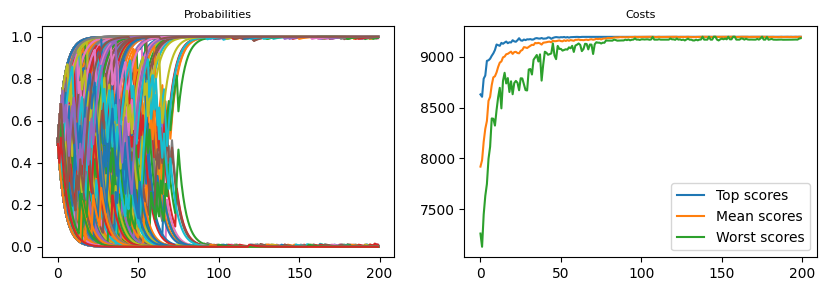

In [ ]:
plot('',data, probabilities)